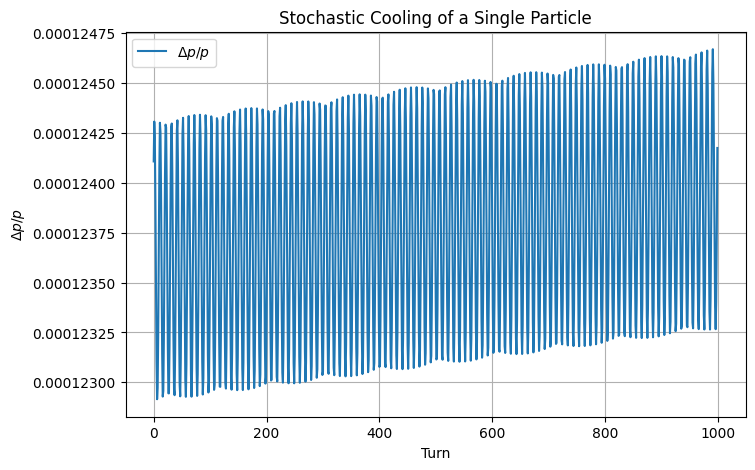

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as sp
import math

# Parameters
betPU, alfPU       =  1.3, -0.9
betK, alfK         =  0.8,  0.6
gamPU, gamK        =  (1 + alfPU**2)/betPU, (1 + alfK**2)/betK
muPUK, muKPU       =  1.51, 2*np.pi*1.34 - 1.51
total_angle        =  2*np.pi*1.34
etaPUK, etaKPU     =  -0.01, -0.01    #eta PUK must be reletevely small, so they dont change slices so fast... 0.02 breaks the system ... It is the limit case!!!! very sensitive on etaPUK --> 2 much unwanted mixing, also etaKPU cant go very low(limit case 0.3) because then the mixing is bad
sigdelt            = .0001            # rms momentum spread in unit
Th, Trev           =  .1e-6, 5.0e-6, # half width of simulation window and revolution period in s
Tovlap, NSamp= 4*sigdelt*abs(etaPUK + etaKPU)*Trev, 800
gainL              =  5e-5
DTSamp   = Th/NSamp
NSampext = math.ceil( Tovlap/DTSamp )
wlL, wrL = -1.6e-9, 1.6e-9
turns = 1000  # Number of turns to track



projPU11 =  betPU**(1/2)
projPU21 = -alfPU/betPU**(1/2)
projPU22 =  1/betPU**(1/2)

matPUK11 = ((betK/betPU)**(1/2))*(np.cos(muPUK) + alfPU*np.sin(muPUK))
matPUK12 = ((betPU*betK)**(1/2))*np.sin(muPUK)
matPUK21 = ((alfPU-alfK)*np.cos(muPUK) - (1+alfPU*alfK)*np.sin(muPUK))/((betPU*betK)**(1/2))
matPUK22 = ((betPU/betK)**(1/2))*(np.cos(muPUK) - alfK*np.sin(muPUK))

matKPU11 = ((betPU/betK)**(1/2))*(np.cos(muKPU) + alfK*np.sin(muKPU))
matKPU12 = ((betPU*betK)**(1/2))*np.sin(muKPU)
matKPU21 = ((alfK-alfPU)*np.cos(muKPU) - (1+alfPU*alfK)*np.sin(muKPU))/((betPU*betK)**(1/2))
matKPU22 = ((betK/betPU)**(1/2))*(np.cos(muKPU) - alfPU*np.sin(muKPU))




# Response function
def respL(Dt):
    return (63e9 * Dt) * (1 - 6.5e18 * Dt**2) * (1 - 1.55e18 * Dt**2) * (1 - (0.625e9 * Dt)**2)**8

# Initialize particle
rng = np.random.default_rng()
xn, xpn, deltn = rng.normal(0., 1.), rng.normal(0., 1.), rng.normal(0., 1.)
Tau = rng.uniform(-Th, Th)

xn=projPU11*xn
xpn=projPU21*xn + projPU22*xpn
deltn=deltn*sigdelt

particle = [ [xn, xpn, 
                     deltn, Tau ] ]

# Storage for plotting
dp_p_history = []

for turn in range(turns):
    # Generate signal at pickup
    TraceL = np.zeros(NSamp + 1 )
    for ind in range(int((wlL+Tau+Th)/DTSamp), 
                          int((wrL+Tau+Th)/DTSamp) ):
        TraceL[ind] = respL(ind  * DTSamp - Th - Tau)
    
    #x_values = DTSamp * np.arange(-NSampext, NSamp + NSampext) - Th
    #y_values = TraceL[-NSampext:] + TraceL[:NSamp + 1 + NSampext]

    
    #print(len(x_values), len(y_values))  # These should be the same


    # Interpolate signal
    csL = sp.CubicSpline(DTSamp * np.arange(NSamp +1) - Th,  TraceL)
    signal_value = csL(Tau)
    

    xnPU=matPUK11*xn + matPUK12*xpn
    xpnPU=matPUK21*xn + matPUK22*xpn
    Tau= Tau + etaPUK*deltn*Trev

    particle = [ [xnPU, xpnPU, 
                     deltn, Tau ] ]

    # Apply correction
    deltn -= gainL * signal_value
    
    # Update longitudinal coordinate
    Tau += etaKPU * deltn * Trev

    xn=matKPU11*xnPU + matKPU12*xpnPU
    xpn=matKPU21*xnPU + matKPU22*xpnPU

    particle = [ [xn, xpn, 
                     deltn, Tau ] ]


    # Store results
    dp_p_history.append(deltn)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(range(turns), dp_p_history, label=r'$\Delta p / p$')
plt.xlabel('Turn')
plt.ylabel(r'$\Delta p / p$')
plt.title('Stochastic Cooling of a Single Particle')
plt.legend()
plt.grid()
plt.show()


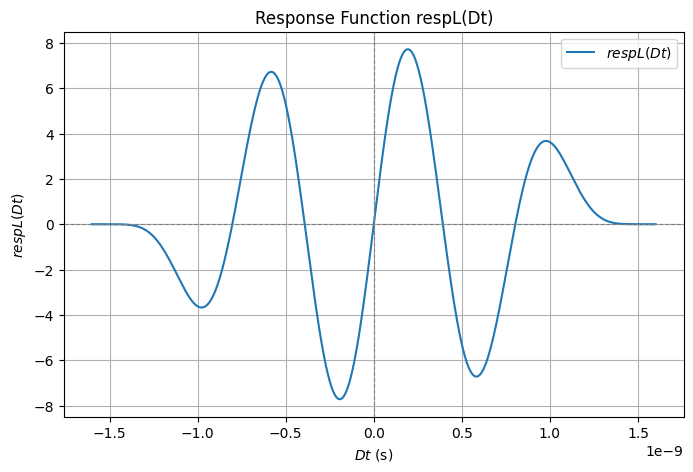

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def respL(Dt):
    return (63e9 * Dt) * (1 - 6.5e18 * Dt**2) * (1 - 1.55e18 * Dt**2) * (1 - (0.625e9 * Dt)**2)**8

# Define the range of Dt
wlL, wrL = -1.6e-9, 1.6e-9
Dt_values = np.linspace(wlL, wrL, 1000)  # 1000 points for smooth curve

# Compute the function values
respL_values = respL(Dt_values)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(Dt_values, respL_values, label=r'$respL(Dt)$')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel(r'$Dt$ (s)')
plt.ylabel(r'$respL(Dt)$')
plt.title("Response Function respL(Dt)")
plt.legend()
plt.grid()
plt.show()

/tmp/vtsianti/ipykernel_3278739/1372489676.py:7: RuntimeWarning: overflow encountered in power
  return (63e9 * Dt) * (1 - 6.5e18 * Dt**2) * (1 - 1.55e18 * Dt**2) * (1 - (0.625e9 * Dt)**2)**8


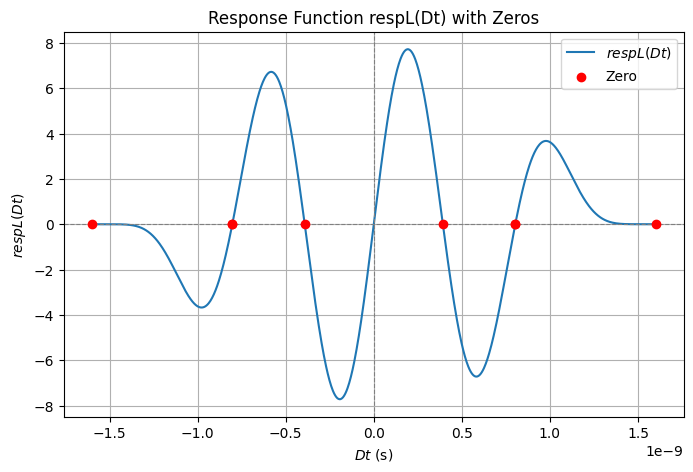

Identified zeros (s): [np.float64(-1.6e-09), np.float64(-8.032193289024989e-10), np.float64(-3.9223227027636805e-10), np.float64(8.032193289024989e-10), np.float64(-8.032193289024989e-10), np.float64(3.9223227027636805e-10), np.float64(8.032193289024989e-10), np.float64(1.6e-09)]


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the function
def respL(Dt):
    return (63e9 * Dt) * (1 - 6.5e18 * Dt**2) * (1 - 1.55e18 * Dt**2) * (1 - (0.625e9 * Dt)**2)**8

# Define the range of Dt
wlL, wrL = -1.6e-9, 1.6e-9
Dt_values = np.linspace(wlL, wrL, 1000)

# Compute the function values
respL_values = respL(Dt_values)

# Find zeros using fsolve
initial_guesses = np.linspace(wlL, wrL, 10)  # Try multiple starting points
zeros = fsolve(respL, initial_guesses)

# Filter zeros to keep only the ones within [wlL, wrL]
zeros = [z for z in zeros if wlL <= z <= wrL]

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(Dt_values, respL_values, label=r'$respL(Dt)$')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Plot zeros
for z in zeros:
    plt.scatter(z, 0, color='red', zorder=3, label="Zero" if 'Zero' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel(r'$Dt$ (s)')
plt.ylabel(r'$respL(Dt)$')
plt.title("Response Function respL(Dt) with Zeros")
plt.legend()
plt.grid()
plt.show()

# Print the identified zeros
print("Identified zeros (s):", zeros)


/tmp/vtsianti/ipykernel_3574866/2975518951.py:7: RuntimeWarning: overflow encountered in power
  return (63e9 * Dt) * (1 - 6.5e18 * Dt**2) * (1 - 1.55e18 * Dt**2) * (1 - (0.625e9 * Dt)**2)**8


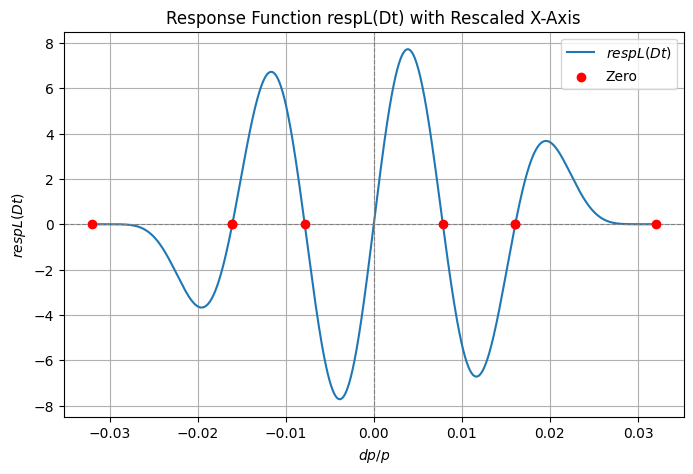

Identified zeros (rescaled): [np.float64(-0.032), np.float64(-0.016064386578049976), np.float64(-0.00784464540552736), np.float64(0.016064386578049976), np.float64(-0.016064386578049976), np.float64(0.00784464540552736), np.float64(0.016064386578049976), np.float64(0.032)]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the function
def respL(Dt):
    return (63e9 * Dt) * (1 - 6.5e18 * Dt**2) * (1 - 1.55e18 * Dt**2) * (1 - (0.625e9 * Dt)**2)**8

# Define the range of Dt
wlL, wrL = -1.6e-9, 1.6e-9

Dt_values = np.linspace(wlL, wrL, 1000)

# Compute function values
respL_values = respL(Dt_values)

# Rescale x-axis by dividing Dt by (0.01 * 5e-6)
scale_factor = 0.01 * 5e-6
Dt_rescaled = Dt_values / scale_factor  # Rescaled x-axis

# Find zeros using fsolve
initial_guesses = np.linspace(wlL, wrL, 10)  # Try multiple starting points
zeros = fsolve(respL, initial_guesses)
zeros = [z for z in zeros if wlL <= z <= wrL]  # Filter within range

# Convert zeros to the new scale
zeros_rescaled = [z / scale_factor  for z in zeros]

# Plot the function with the rescaled x-axis
plt.figure(figsize=(8, 5))
plt.plot(Dt_rescaled, respL_values, label=r'$respL(Dt)$')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Plot zeros
for z in zeros_rescaled:
    plt.scatter(z, 0, color='red', zorder=3, label="Zero" if 'Zero' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel(r'$dp/p$')
plt.ylabel(r'$respL(Dt)$')
plt.title("Response Function respL(Dt) with Rescaled X-Axis")
plt.legend()
plt.grid()
plt.show()

# Print the rescaled zeros
print("Identified zeros (rescaled):", zeros_rescaled)


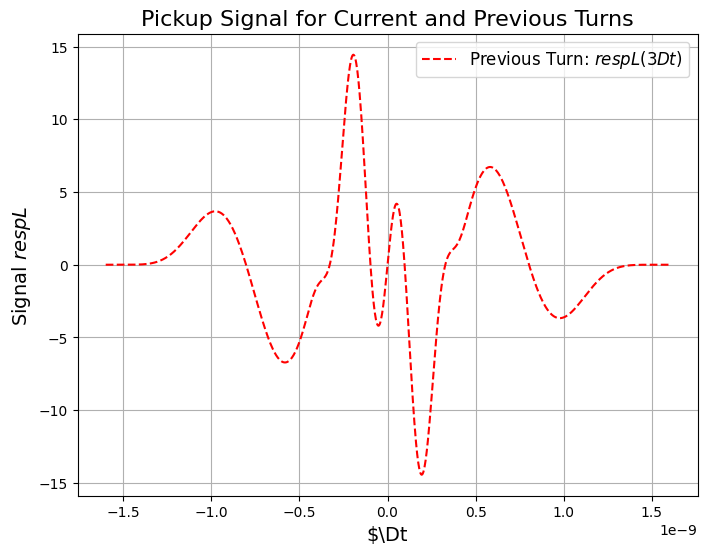

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the response function
def respL(Dt):
    # Create an array of zeros with the same shape as Dt
    result = np.zeros_like(Dt)
    
    # Apply the function only where Dt is within bounds
    mask = (Dt >= -1.6e-9) & (Dt <= 1.6e-9)
    result[mask] = (63e9 * Dt[mask]) * (1 - 6.5e18 * Dt[mask]**2) * (1 - 1.55e18 * Dt[mask]**2) * (1 - (0.625e9 * Dt[mask])**2)**8

    return result
# Constants
eta = 0.01  # Example value for slip factor
Trev = 5e-6  # Example value for revolution period

# Define δ range (momentum deviation)
dt = np.linspace(-1.6e-9, 1.6e-9, 1000)  # Adjust range as needed
dtn=3*dt
# Compute Dt for current and previous turn
  # Previous turn signal

# Compute function values
respL_previous = respL(dtn)  # Current turn signal
respL_current = respL(dt)  # Previous turn signal

# Plot
plt.figure(figsize=(8, 6))
#plt.plot(dt, respL_current, label=r'Current Turn: $respL(Dt)$', color='blue')
plt.plot(dt, respL_previous-respL_current, label=r'Previous Turn: $respL(3Dt)$', color='red', linestyle='--')

# Labels, title, legend
plt.xlabel(r'$\Dt', fontsize=14)
plt.ylabel(r'Signal $respL$', fontsize=14)
plt.title('Pickup Signal for Current and Previous Turns', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

Zero crossings of respL(3Dt) - respL(Dt): [-1.60000000e-09 -8.05605606e-10 -3.28328328e-10 -9.76976977e-11
 -1.60160160e-12  9.44944945e-11  3.25125125e-10  8.02402402e-10
  1.59679680e-09]


<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
/tmp/vtsianti/ipykernel_3574866/3004932702.py:37: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Zero Crossings of $\Delta$ Signal', fontsize=16)


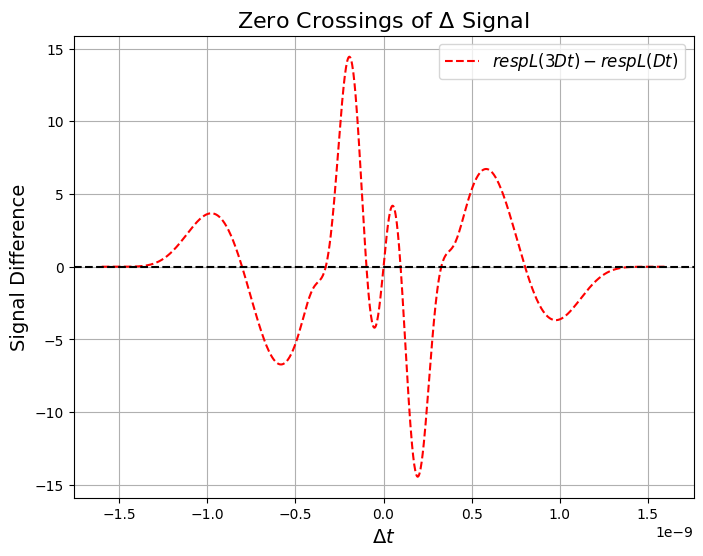

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the response function
def respL(Dt):
    result = np.zeros_like(Dt)
    mask = (Dt >= -1.6e-9) & (Dt <= 1.6e-9)
    result[mask] = (63e9 * Dt[mask]) * (1 - 6.5e18 * Dt[mask]**2) * (1 - 1.55e18 * Dt[mask]**2) * (1 - (0.625e9 * Dt[mask])**2)**8
    return result

# Define Dt range
dt = np.linspace(-1.6e-9, 1.6e-9, 1000)
dtn = 3 * dt

# Compute function values
respL_current = respL(dt)  
respL_previous = respL(dtn)  

# Compute the difference
signal_difference = respL_previous - respL_current

# Find zero crossings
zero_indices = np.where(np.diff(np.sign(signal_difference)))[0]
zero_points = dt[zero_indices]

# Print zero crossings
print("Zero crossings of respL(3Dt) - respL(Dt):", zero_points)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(dt, signal_difference, label=r'$respL(3Dt) - respL(Dt)$', color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='--')  # Reference line at y=0

# Labels, title, legend
plt.xlabel(r'$\Delta t$', fontsize=14)
plt.ylabel(r'Signal Difference', fontsize=14)
plt.title('Zero Crossings of $\Delta$ Signal', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


Zero crossings of respL(3Dt) - respL(Dt) (scaled): [-3.20000000e-02 -1.61121121e-02 -6.56656657e-03 -1.95395395e-03
 -3.20320320e-05  1.88988989e-03  6.50250250e-03  1.60480480e-02
  3.19359359e-02]


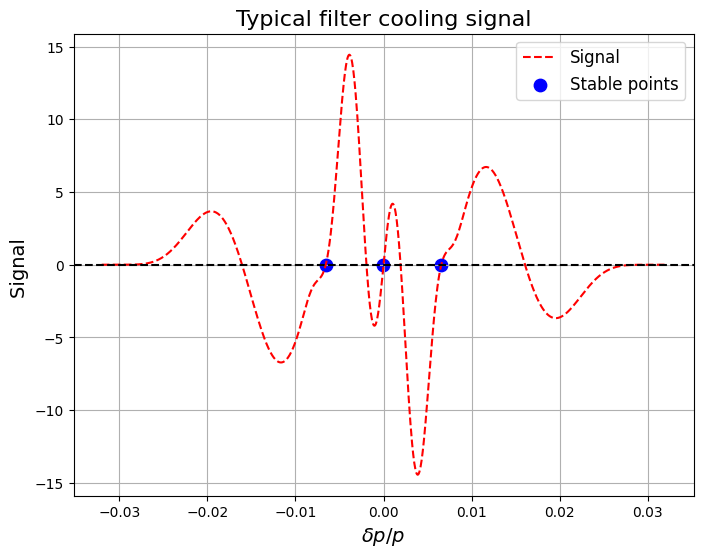

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the response function
def respL(Dt):
    result = np.zeros_like(Dt)
    mask = (Dt >= -1.6e-9) & (Dt <= 1.6e-9)
    result[mask] = (63e9 * Dt[mask]) * (1 - 6.5e18 * Dt[mask]**2) * (1 - 1.55e18 * Dt[mask]**2) * (1 - (0.625e9 * Dt[mask])**2)**8
    return result

# Define Dt range
dt = np.linspace(-1.6e-9, 1.6e-9, 1000)
dtn = 3 * dt

# Compute function values
respL_current = respL(dt)  
respL_previous = respL(dtn)  

# Compute the difference
signal_difference = respL_previous - respL_current

# Apply scale factor
scale_factor = 0.01 * 5e-6
dt_scaled = dt / scale_factor  # Apply scaling to x-axis

# Find zero crossings
zero_points_x_need = np.zeros(3)
zero_points_y_need = np.zeros(3)
zero_indices = np.where(np.diff(np.sign(signal_difference)))[0]
zero_points_x = dt_scaled[zero_indices]  # Scaled zero x-values
zero_points_x_need[0]=zero_points_x[2]
zero_points_x_need[1]=zero_points_x[4]
zero_points_x_need[2]=zero_points_x[6]
zero_points_y = np.zeros_like(zero_points_x)  # All zeros for y-values
zero_points_y_need[0]=zero_points_y[2]
zero_points_y_need[1]=zero_points_y[4]
zero_points_y_need[2]=zero_points_y[6]

# Print zero crossings
print("Zero crossings of respL(3Dt) - respL(Dt) (scaled):", zero_points_x)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(dt_scaled, signal_difference, label=r'Signal', color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='--')  # Reference line at y=0

# Mark zero crossings
plt.scatter(zero_points_x_need, zero_points_y_need, color='blue', marker='o', s=80, label='Stable points')

# Labels, title, legend
plt.xlabel(r'$\delta p / p$', fontsize=14)
plt.ylabel(r'Signal ', fontsize=14)
plt.title('Typical filter cooling signal', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()




Zero crossings of respL(3Dt) - respL(Dt) (scaled): [-3.20000000e-02 -1.61121121e-02 -6.56656657e-03 -1.95395395e-03
 -3.20320320e-05  1.88988989e-03  6.50250250e-03  1.60480480e-02
  3.19359359e-02]


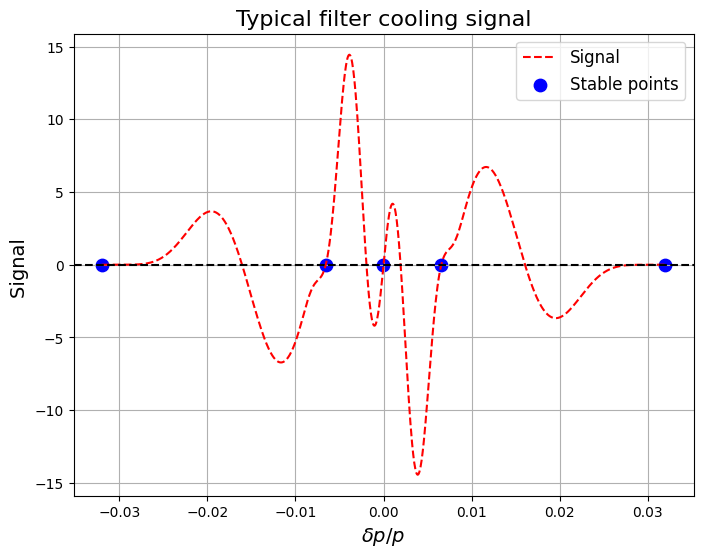

In [35]:
# Define the response function
def respL(Dt):
    result = np.zeros_like(Dt)
    mask = (Dt >= -1.6e-9) & (Dt <= 1.6e-9)
    result[mask] = (63e9 * Dt[mask]) * (1 - 6.5e18 * Dt[mask]**2) * (1 - 1.55e18 * Dt[mask]**2) * (1 - (0.625e9 * Dt[mask])**2)**8
    return result

# Define Dt range
dt = np.linspace(-1.6e-9, 1.6e-9, 1000)
dtn = 3 * dt

# Compute function values
respL_current = respL(dt)  
respL_previous = respL(dtn)  

# Compute the difference
signal_difference = respL_previous - respL_current

# Apply scale factor
scale_factor = 0.01 * 5e-6
dt_scaled = dt / scale_factor  # Apply scaling to x-axis

# Find zero crossings
zero_points_x_need = np.zeros(5)
zero_points_y_need = np.zeros(5)
zero_indices = np.where(np.diff(np.sign(signal_difference)))[0]
zero_points_x = dt_scaled[zero_indices]  # Scaled zero x-values
zero_points_x_need[0]=zero_points_x[0]
zero_points_x_need[1]=zero_points_x[2]
zero_points_x_need[2]=zero_points_x[4]
zero_points_x_need[3]=zero_points_x[6]
zero_points_x_need[4]=zero_points_x[8]
zero_points_y = np.zeros_like(zero_points_x)  # All zeros for y-values
zero_points_y_need[0]=zero_points_y[0]
zero_points_y_need[1]=zero_points_y[2]
zero_points_y_need[2]=zero_points_y[4]
zero_points_y_need[3]=zero_points_y[6]
zero_points_y_need[4]=zero_points_y[8]

# Print zero crossings
print("Zero crossings of respL(3Dt) - respL(Dt) (scaled):", zero_points_x)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(dt_scaled, signal_difference, label=r'Signal', color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='--')  # Reference line at y=0

# Mark zero crossings
plt.scatter(zero_points_x_need, zero_points_y_need, color='blue', marker='o', s=80, label='Stable points')

# Labels, title, legend
plt.xlabel(r'$\delta p / p$', fontsize=14)
plt.ylabel(r'Signal ', fontsize=14)
plt.title('Typical filter cooling signal', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()



Zero crossings of respL(3Dt) - respL(Dt) (scaled): [-3.20000000e-02 -1.61121121e-02 -6.56656657e-03 -1.95395395e-03
 -3.20320320e-05  1.88988989e-03  6.50250250e-03  1.60480480e-02
  3.19359359e-02]


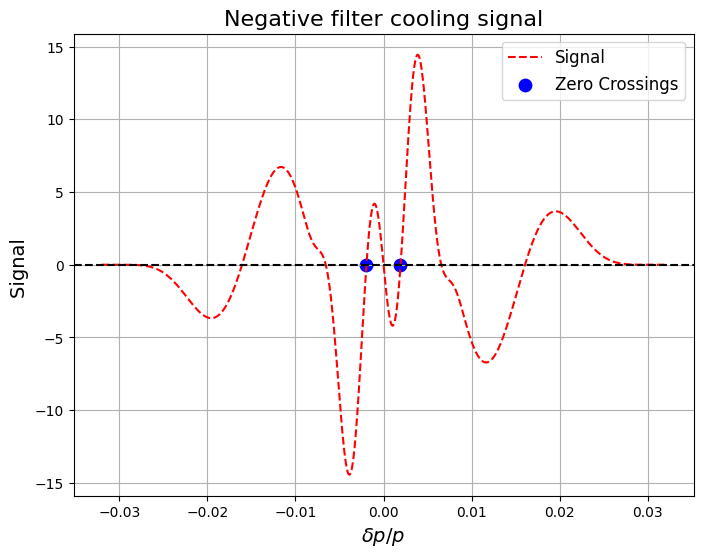

In [37]:
# Define the response function
def respL(Dt):
    result = np.zeros_like(Dt)
    mask = (Dt >= -1.6e-9) & (Dt <= 1.6e-9)
    result[mask] = -(63e9 * Dt[mask]) * (1 - 6.5e18 * Dt[mask]**2) * (1 - 1.55e18 * Dt[mask]**2) * (1 - (0.625e9 * Dt[mask])**2)**8
    return result

# Define Dt range
dt = np.linspace(-1.6e-9, 1.6e-9, 1000)
dtn = 3 * dt

# Compute function values
respL_current = respL(dt)  
respL_previous = respL(dtn)  

# Compute the difference
signal_difference = respL_previous - respL_current

# Apply scale factor
scale_factor = 0.01 * 5e-6
dt_scaled = dt / scale_factor  # Apply scaling to x-axis

# Find zero crossings
zero_points_x_need = np.zeros(2)
zero_points_y_need = np.zeros(2)
zero_indices = np.where(np.diff(np.sign(signal_difference)))[0]
zero_points_x = dt_scaled[zero_indices]  # Scaled zero x-values
zero_points_x_need[0]=zero_points_x[3]
zero_points_x_need[1]=zero_points_x[5]

zero_points_y = np.zeros_like(zero_points_x)  # All zeros for y-values
zero_points_y_need[0]=zero_points_y[3]
zero_points_y_need[1]=zero_points_y[5]


# Print zero crossings
print("Zero crossings of respL(3Dt) - respL(Dt) (scaled):", zero_points_x)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(dt_scaled, signal_difference, label=r'Signal', color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='--')  # Reference line at y=0

# Mark zero crossings
plt.scatter(zero_points_x_need, zero_points_y_need, color='blue', marker='o', s=80, label='Zero Crossings')

# Labels, title, legend
plt.xlabel(r'$\delta p / p$', fontsize=14)
plt.ylabel(r'Signal ', fontsize=14)
plt.title('Negative filter cooling signal', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()